<a href="https://colab.research.google.com/github/Stephane-Masamba/Team_4_CPT_ML-Classification/blob/Mikael/Copy_of_Mikael_Daniels_Classification2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                                       *Climate* *Change* *Belief* *Analysis*



---











#Introduction

Many companies are built around lessening their environmental impact and thus they offer products that are environmentally friendly and sustainable. With that, they would like to determine how people perceive climate change.






This notebook aims to build Machine Learning Classification model(s) that is able to classify accurately whether or not a person believes in climate change based on their novel tweet.
 

This will be done by importing necesarry libraries as well as the training and test datasets. Data cleaning follows together with exploratory data analysis.We then wrap up the notebook by diving into different classification techniques under the Modelling section which will be followed by insights and a conclusion.




The following are some of the few Classification techniques explored in this notebook:

1.Support Vector Machines

2.Naive Bayes Classfier

3.K-Nearest Neighbors

4.Random Forest

5.Tree based models

Because this is Sentiment Analysis,the interpretation and classification of emotions within text data, we will use some natural language preprocessing techniques libraries like nltk,spacy together with scikit learn.

#*COMET*

In [ ]:
!pip install comet_ml

In [ ]:
import comet_ml

#Imports

###Import Libraries

In [ ]:
!pip install spacy
!pip install NLTK

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from numpy import arange
import seaborn as sns

#Natural Language Processing
import re
import spacy.cli
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer


#Matrix measurement
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

#Resampling techniques
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

#Machine Learning Models
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import  KFold


from wordcloud import WordCloud 

# from google.colab import drive

In [ ]:
spacy.cli.download('en_core_web_sm')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stop = nltk.corpus.stopwords.words('english')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
nlp = spacy.load('en_core_web_sm')

#Read in the datasets

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/Stephane-Masamba/Team_4_CPT_ML-Classification/Mikael/train%20(1).csv')
print(train.head())

   sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954


In [ ]:
test = pd.read_csv('https://raw.githubusercontent.com/Stephane-Masamba/Team_4_CPT_ML-Classification/Mikael/test%20(1).csv')
print(test.head())

                                             message  tweetid
0  Europe will now be looking to China to make su...   169760
1  Combine this with the polling of staffers re c...    35326
2  The scary, unimpeachable evidence that climate...   224985
3  @Karoli @morgfair @OsborneInk @dailykos \nPuti...   476263
4  RT @FakeWillMoore: 'Female orgasms cause globa...   872928


#Data description

The data available aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were collected. Each tweet is labelled as one of four classes.



###Classes and description

Class 2 : News-the tweet links to factual news about climate change

Class 1 : Pro-the tweet supports the belief of man-made climate change

Class 0 : Neutral-the tweet neither supports nor refutes the belief of man-made climate change

Class -1 : Anti-the tweet does not believe in man-made climate change

###Variables definitions

sentiment: Sentiment of tweet

message: Tweet body

tweetid: Twitter unique id

#Data Cleaning

Knowing that we are dealing with text data, we decided to first clean the data by making all tweets lower-case, removing punctuation marks and removing white spaces before doing anything else. Also, replacing all links with the word 'LINK' and all user handles with 'USER_REF'

In [ ]:
def clean_text(df):
    i = 0
    for tweet in df['message']:
      tweet = tweet.lower()
      tweet = re.sub(r'http\S+', 'LINK', tweet)
      tweet = re.sub(r'@\S+', 'USER_REF', tweet)
      tweet = re.sub(r'[^\w\s]', '', tweet)
      tweet = tweet.lstrip()
      tweet = tweet.rstrip()
      tweet = tweet.replace('  ', ' ')
      df.loc[i, 'message'] = tweet
      i += 1

      return df

In [ ]:
clean_text(train)
train

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954
...,...,...,...
15814,1,RT @ezlusztig: They took down the material on ...,22001
15815,2,RT @washingtonpost: How climate change could b...,17856
15816,0,notiven: RT: nytimesworld :What does Trump act...,384248
15817,-1,RT @sara8smiles: Hey liberals the climate chan...,819732


In [ ]:
clean_text(test)

,message,tweetid
0,europe will now be looking to china to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928
...,...,...
10541,"RT @BrittanyBohrer: Brb, writing a poem about ...",895714
10542,2016: the year climate change came home: Durin...,875167
10543,RT @loop_vanuatu: Pacific countries positive a...,78329
10544,"RT @xanria_00018: You’re so hot, you must be t...",867455


Here we add 'LINK' and 'USER_REF' to our list of stop words and remove all stop words from each tweet

In [ ]:
def remove_stopwords(df):
    my_stop_words = stopwords.words('english')
    my_stop_words.append('LINK')
    my_stop_words.append('USER_REF')

    df_index = 0

    for tweet in df['message']:
      tweet = word_tokenize(tweet)
      tweet = [word for word in tweet if not word in my_stop_words]
      tweet = ' '.join(tweet)

      df.loc[df_index, 'message'] = tweet
      df_index += 1

    return df

In [ ]:
remove_stopwords(train)

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,It 's like lack evidence anthropogenic global ...,126103
2,2,RT @ RawStory : Researchers say three years ac...,698562
3,1,# TodayinMaker # WIRED : 2016 pivotal year war...,573736
4,1,"RT @ SoyNovioDeTodas : It 's 2016 , racist , s...",466954
...,...,...,...
15814,1,RT @ ezlusztig : They took material global war...,22001
15815,2,RT @ washingtonpost : How climate change could...,17856
15816,0,notiven : RT : nytimesworld : What Trump actua...,384248
15817,-1,RT @ sara8smiles : Hey liberals climate change...,819732


In [ ]:
remove_stopwords(test)

,message,tweetid
0,europe looking china make sure alone fighting ...,169760
1,Combine polling staffers climate change womens...,35326
2,"The scary , unimpeachable evidence climate cha...",224985
3,@ Karoli @ morgfair @ OsborneInk @ dailykos Pu...,476263
4,RT @ FakeWillMoore : 'Female orgasms cause glo...,872928
...,...,...
10541,"RT @ BrittanyBohrer : Brb , writing poem clima...",895714
10542,2016 : year climate change came home : During ...,875167
10543,RT @ loop_vanuatu : Pacific countries positive...,78329
10544,"RT @ xanria_00018 : You ’ hot , must cause glo...",867455


###Find all named entities for each tweet

In [ ]:
def entities(df):
    df_index = 0

    for tweet in df['message']:
      tweet = nlp(tweet)

      for entity in tweet.ents:
        df.loc[df_index, 'message'] = df.loc[df_index, 'message'].replace(str(entity.text), str(entity.label_))

      df_index += 1

      return df

In [ ]:
entities(train)

,sentiment,message,tweetid
0,1,ORG chief doesnt think carbon dioxide main cau...,625221
1,1,It 's like lack evidence anthropogenic global ...,126103
2,2,RT @ RawStory : Researchers say three years ac...,698562
3,1,# TodayinMaker # WIRED : 2016 pivotal year war...,573736
4,1,"RT @ SoyNovioDeTodas : It 's 2016 , racist , s...",466954
...,...,...,...
15814,1,RT @ ezlusztig : They took material global war...,22001
15815,2,RT @ washingtonpost : How climate change could...,17856
15816,0,notiven : RT : nytimesworld : What Trump actua...,384248
15817,-1,RT @ sara8smiles : Hey liberals climate change...,819732


In [ ]:
entities(test)

,message,tweetid
0,LOC looking GPE make sure alone fighting clima...,169760
1,Combine polling staffers climate change womens...,35326
2,"The scary , unimpeachable evidence climate cha...",224985
3,@ Karoli @ morgfair @ OsborneInk @ dailykos Pu...,476263
4,RT @ FakeWillMoore : 'Female orgasms cause glo...,872928
...,...,...
10541,"RT @ BrittanyBohrer : Brb , writing poem clima...",895714
10542,2016 : year climate change came home : During ...,875167
10543,RT @ loop_vanuatu : Pacific countries positive...,78329
10544,"RT @ xanria_00018 : You ’ hot , must cause glo...",867455


###Lemmatize every word in each tweet

In [ ]:
def lem_text(df):
    df_index = 0

    for tweet in df['message']:
      tweet = nlp(tweet)
      
      for token in tweet:
        df.loc[df_index, 'message'] = df.loc[df_index, 'message'].replace(str(token.text), str(token.lemma_))

      df_index += 1

      return df

In [ ]:
lem_text(train)

,sentiment,message,tweetid
0,1,ORG chief donot think carbon dioxide main caus...,625221
1,1,It 's like lack evidence anthropogenic global ...,126103
2,2,RT @ RawStory : Researchers say three years ac...,698562
3,1,# TodayinMaker # WIRED : 2016 pivotal year war...,573736
4,1,"RT @ SoyNovioDeTodas : It 's 2016 , racist , s...",466954
...,...,...,...
15814,1,RT @ ezlusztig : They took material global war...,22001
15815,2,RT @ washingtonpost : How climate change could...,17856
15816,0,notiven : RT : nytimesworld : What Trump actua...,384248
15817,-1,RT @ sara8smiles : Hey liberals climate change...,819732


In [ ]:
lem_text(test)

,message,tweetid
0,LOC look GPE make sure alone fight climate change,169760
1,Combine polling staffers climate change womens...,35326
2,"The scary , unimpeachable evidence climate cha...",224985
3,@ Karoli @ morgfair @ OsborneInk @ dailykos Pu...,476263
4,RT @ FakeWillMoore : 'Female orgasms cause glo...,872928
...,...,...
10541,"RT @ BrittanyBohrer : Brb , writing poem clima...",895714
10542,2016 : year climate change came home : During ...,875167
10543,RT @ loop_vanuatu : Pacific countries positive...,78329
10544,"RT @ xanria_00018 : You ’ hot , must cause glo...",867455


#Exploratory Data Analysis

Now it is time to analyse the data and how it is structured.

###Missing values

In [ ]:
train.isnull().sum()


sentiment    0
message      0
tweetid      0
dtype: int64

In [ ]:
test.isnull().sum()

message    0
tweetid    0
dtype: int64

There are no missing values in both the train and test datasets

###Sentiment Classes

In [ ]:
train.sentiment.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

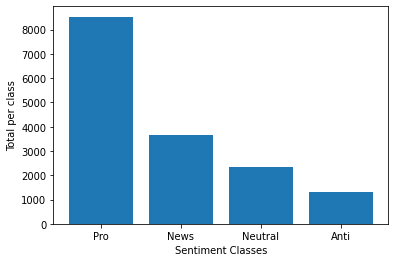

In [ ]:
counts = train["sentiment"].value_counts()
plt.bar(range(len(counts)), counts)
plt.xticks([0, 1, 2, 3], ['Pro', 'News', 'Neutral', 'Anti'])

plt.ylabel("Total per class")
plt.xlabel("Sentiment Classes")
plt.show()

In [ ]:
#Percentage of the major class
len(train[train.sentiment==1])/len(train.sentiment)

0.5392249826158417

The 'Pro' climate change class accounts for 54% of the data set and the remaining 46% is shared amongst the three other classes. This imbalance indicates how biased our model might me thus exploring resampling techniques might be required in order to improve the model accuracy.

###Distribution of the classes

In [ ]:
train['sentiment_length'] = train['sentiment'].astype(str).str.len()


Text(0.5, 1.0, 'Sentiment length distribution')

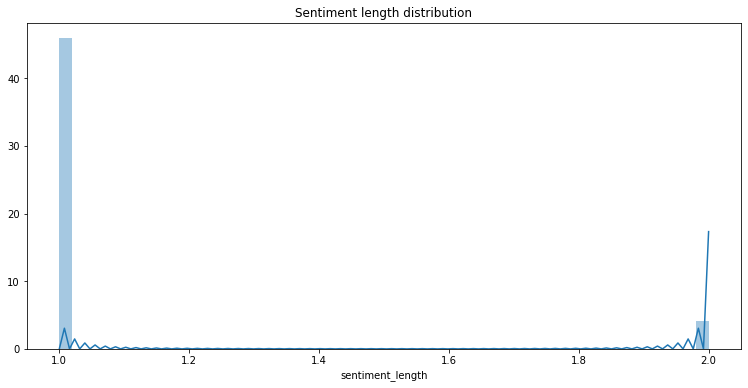

In [ ]:
plt.figure(figsize=(12.8,6))
sns.distplot(train['sentiment_length']).set_title('Sentiment length distribution')

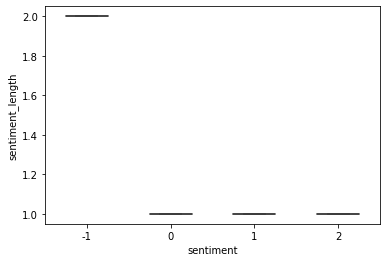

In [ ]:
sns.boxplot(data=train, x='sentiment',y='sentiment_length',width=.5)

###Word Cloud

Below we show some of the words used in the different tweets under each class

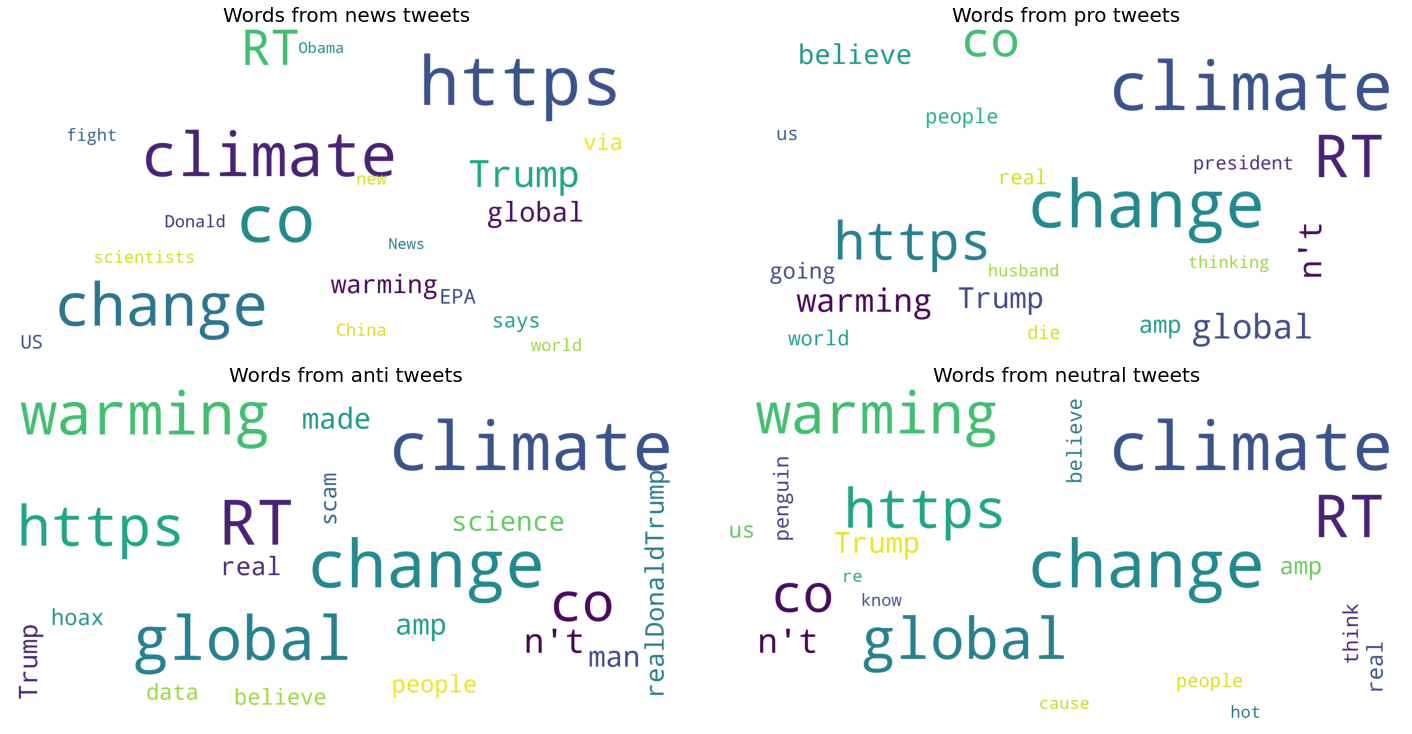

In [ ]:
#word clouds
news = train[train['sentiment'] == 2]['message']
pro = train[train['sentiment'] == 1]['message']
neutral =train[train['sentiment'] == 0]['message']
Anti = train[train['sentiment'] ==-1]['message']


news = [word for line in news for word in line.split()]
pro = [word for line in pro for word in line.split()]
neutral = [word for line in neutral for word in line.split()]
Anti= [word for line in Anti for word in line.split()]

news = WordCloud(
    background_color='white',
    max_words=20,
    max_font_size=40,
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(news))

pro = WordCloud(
    background_color='white',
    max_words=20,
    max_font_size=40,
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(pro))



neutral = WordCloud(
    background_color='white',
    max_words=20,
    max_font_size=40,
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(neutral))


Anti = WordCloud(
    background_color='white',
    max_words=20,
    max_font_size=40,
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(Anti))


fig, axs = plt.subplots(2, 2, figsize = (20, 10))
fig.tight_layout(pad = 0)

axs[0, 0].imshow(news)
axs[0, 0].set_title('Words from news tweets', fontsize = 20)
axs[0, 0].axis('off')

axs[0, 1].imshow(pro)
axs[0, 1].set_title('Words from pro tweets', fontsize = 20)
axs[0, 1].axis('off')


axs[1, 0].imshow(Anti)
axs[1, 0].set_title('Words from anti tweets', fontsize = 20)
axs[1, 0].axis('off')

axs[1, 1].imshow(neutral)
axs[1, 1].set_title('Words from neutral tweets', fontsize = 20)
axs[1, 1].axis('off')

plt.savefig('joint_cloud.png')

#Define our feature and target variable to use when modelling

In [ ]:
X = train['message']
X

0        ORG chief donot think carbon dioxide main caus...
1        It 's like lack evidence anthropogenic global ...
2        RT @ RawStory : Researchers say three years ac...
3        # TodayinMaker # WIRED : 2016 pivotal year war...
4        RT @ SoyNovioDeTodas : It 's 2016 , racist , s...
                               ...                        
15814    RT @ ezlusztig : They took material global war...
15815    RT @ washingtonpost : How climate change could...
15816    notiven : RT : nytimesworld : What Trump actua...
15817    RT @ sara8smiles : Hey liberals climate change...
15818    RT @ Chet_Cannon : . @ kurteichenwald 's 'clim...
Name: message, Length: 15819, dtype: object

In [ ]:
y = train['sentiment']
y

0        1
1        1
2        2
3        1
4        1
        ..
15814    1
15815    2
15816    0
15817   -1
15818    0
Name: sentiment, Length: 15819, dtype: int64

###Convert features to machine language

In [ ]:
tf_vecto = TfidfVectorizer(lowercase = True,stop_words = 'english',ngram_range=(1, 2))
X = tf_vecto.fit_transform(X)

###Splitting the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
#X_test = test['message']

In [ ]:
#X_test = tf_vect.transform(X_test)

#Modelling

##Modelling with maximum data cleaning

The function below takes in a model and returns the average accuracy score

In [ ]:
def accuracy(model):
    features = train['message']
    target = train['sentiment']

    train_scores = []
    test_scores = []

    #tf_vect = TfidfVectorizer(ngram_range=(1, 2))
    tf_vecto = TfidfVectorizer(lowercase = True,stop_words = 'english',ngram_range=(1, 2))


    folds = KFold(n_splits=5, shuffle=True)

    for train_index, test_index in folds.split(features):
        x_train, x_test = features.iloc[train_index], features.iloc[test_index]    
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        x_train = tf_vecto.fit_transform(x_train)
        x_test = tf_vecto.transform(x_test)
     
        model.fit(x_train, y_train)
        train_predictions = model.predict(x_train)
        test_predictions = model.predict(x_test)

        train_score = accuracy_score(y_train, train_predictions)
        train_scores.append(train_score)

        test_score = accuracy_score(y_test, test_predictions)
        test_scores.append(test_score)

    avg_train_accuracy = np.mean(train_scores)
    avg_test_accuracy = np.mean(test_scores)

    return [avg_train_accuracy, avg_test_accuracy]


###Support Vector Machines(SVM)

SVM or Support Vector Machine is a linear model for classification and regression problems. It can solve linear and non-linear problems and work well for many practical problems. The idea of SVM is simple: The algorithm creates a line or a hyperplane which separates the data into classes

In [ ]:
sv = SVC()

sv_accuracy = accuracy(sv)
sv_accuracy

[0.9855395497849424, 0.7233707097672081]

###Bernoulli Naive Bayes

The Bernoulli naive Bayes classifier assumes that all our features are binary such that they take only two values (e.g. a nominal categorical feature that has been one-hot encoded)

In [ ]:
bernoulli = BernoulliNB()

bernoulli_accuracy = accuracy(bernoulli)
bernoulli_accuracy

[0.705970732824481, 0.5911872140460995]

###Multi Nomial Naive Bayes

In summary, Naive Bayes classifier is a general term which refers to conditional independence of each of the features in the model, while Multinomial Naive Bayes classifier is a specific instance of a Naive Bayes classifier which uses a multinomial distribution for each of the features

In [ ]:
mnb = MultinomialNB()

mnb_accuracy = accuracy(mnb)
mnb_accuracy

[0.7267526277196893, 0.6323412337580583]

###Stochastic Gradient Descent (SGD)

 SGD is a simple,efficient approach to fitting linear classifiers and regressors under convex loss functions such as (linear) Support Vector Machines and Logistic Regression.It has received a considerable amount of attention just recently in the context of large-scale learning.

In [ ]:
sgd = SGDClassifier()

sgd_accuracy = accuracy(sgd)
sgd_accuracy

[0.9713793411757419, 0.7392374216255991]

###Random Forest

The random forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree.

In [ ]:
rand_forest = RandomForestClassifier()

rand_forest_accuracy = accuracy(rand_forest)
rand_forest_accuracy

[0.9998103553858826, 0.6753267973203119]

###K-Nearest Neighbors (KNN)

In pattern recognition, the k-nearest neighbors algorithm (k-NN) is a non-parametric method proposed by Thomas Cover used for classification and regression. In both cases, the input consists of the k closest training examples in the feature space. ... In k-NN classification, the output is a class membership.

In [ ]:
knn = KNeighborsClassifier()

knn_accuracy = accuracy(knn)
knn_accuracy

[0.7575383262713029, 0.6555415352849177]

###Gradient Boosting Classifier

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.

In [ ]:
grad_booster = GradientBoostingClassifier()

grad_booster_accuracy = accuracy(grad_booster)
grad_booster_accuracy

[0.7085309294957446, 0.6562998489567866]

###Extra Trees Classifier

An extra-trees classifier is a class that implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The number of trees in the forest.

In [ ]:
extra_trees = ExtraTreesClassifier()

extra_trees_accuracy = accuracy(extra_trees)
extra_trees_accuracy

[0.9997945513558548, 0.7078189343999219]

###Bagging

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. ... If None, then the base estimator is a decision tree.

In [ ]:
bagging = BaggingClassifier()

bagging_accuracy = accuracy(bagging)
bagging_accuracy

[0.9748403438325571, 0.5958654768133279]

###Decision Tree Classifier

The decision tree classifier (Pang-Ning et al., 2006) creates the classification model by building a decision tree. Each node in the tree specifies a test on an attribute, each branch descending from that node corresponds to one of the possible values for that attribute.

In [ ]:
dec_tree = DecisionTreeClassifier()

dec_tree_accuracy = accuracy(dec_tree)
dec_tree_accuracy

[0.9998103553858824, 0.5783565946809925]

###Linear SVC

SVM or Support Vector Machine is a linear model for classification and regression problems. It can solve linear and non-linear problems and work well for many practical problems. The idea of SVM is simple: The algorithm creates a line or a hyperplane which separates the data into classes

In [ ]:
linear_sv = LinearSVC()

linear_sv_accuracy = accuracy(linear_sv)
linear_sv_accuracy

[0.9994942772828057, 0.7479611164647495]

##Plot all models and respective accuracy scores

Below is a graph of all models which allows for simplified comparison


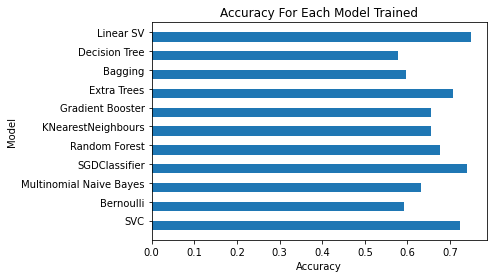

In [ ]:
models = ['SVC', 'Bernoulli', 'Multinomial Naive Bayes', 'SGDClassifier', 'Random Forest', 'KNearestNeighbours', 'Gradient Booster', 'Extra Trees', 'Bagging', 'Decision Tree', 'Linear SV']
bar_widths = [sv_accuracy[1], bernoulli_accuracy[1], mnb_accuracy[1], sgd_accuracy[1], rand_forest_accuracy[1], knn_accuracy[1], grad_booster_accuracy[1], extra_trees_accuracy[1], bagging_accuracy[1], dec_tree_accuracy[1], linear_sv_accuracy[1]]
bar_positions = arange(11) + 0.75
tick_positions = range(1,12)

fig, ax = plt.subplots()
ax.barh(bar_positions, bar_widths, 0.5)
ax.set_yticks(tick_positions)
ax.set_yticklabels(models)

ax.set_ylabel('Model')
ax.set_xlabel('Accuracy')
ax.set_title('Accuracy For Each Model Trained')

plt.show()

###Fit best models and use the metrics module

In [ ]:
linear_sv.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
#confusion matrix and classification_report
y_pred = linear_sv.predict(X_test)

print(confusion_matrix(y_test,y_pred))

print('\n\nAccuracy score: ' + str(accuracy_score(y_test, y_pred)))
print("\n\nClassification Report:\n\n", classification_report(y_test,y_pred,target_names=['Anti', 'Neutral','Pro','News']))

[[ 107   25  135   11]
 [   7  144  255   19]
 [   4   47 1589  115]
 [   5    6  150  545]]


Accuracy score: 0.7537926675094817


Classification Report:

               precision    recall  f1-score   support

        Anti       0.87      0.38      0.53       278
     Neutral       0.65      0.34      0.45       425
         Pro       0.75      0.91      0.82      1755
        News       0.79      0.77      0.78       706

    accuracy                           0.75      3164
   macro avg       0.76      0.60      0.64      3164
weighted avg       0.75      0.75      0.73      3164



Below is a visual of the confusion matrix

In [ ]:
sentiment_code = {1:'Pro', 2:'News', 0:'Neutral', -1:'Anti'}

In [ ]:
train['sentiment_code'] = train['sentiment'].map(sentiment_code)

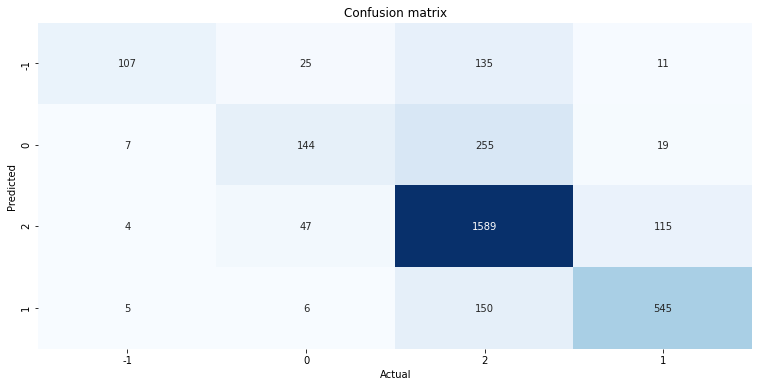

In [ ]:
aux_train = train[['sentiment', 'sentiment_code']].drop_duplicates().sort_values('sentiment_code')
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            cbar=False,
            fmt='g',
            xticklabels=aux_train['sentiment'].values, 
            yticklabels=aux_train['sentiment'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [ ]:
sgd.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
y_predict = sgd.predict(X_test)

print(confusion_matrix(y_test,y_predict))

print('\n\nAccuracy score: ' + str(accuracy_score(y_test, y_pred)))
print("\n\nClassification Report:\n\n", classification_report(y_test,y_predict,target_names=['Anti', 'Neutral','Pro','News']))



[[  89   20  153   16]
 [   6  118  281   20]
 [   5   24 1607  119]
 [   5    6  161  534]]


Accuracy score: 0.7537926675094817


Classification Report:

               precision    recall  f1-score   support

        Anti       0.85      0.32      0.46       278
     Neutral       0.70      0.28      0.40       425
         Pro       0.73      0.92      0.81      1755
        News       0.78      0.76      0.77       706

    accuracy                           0.74      3164
   macro avg       0.76      0.57      0.61      3164
weighted avg       0.75      0.74      0.72      3164



In [ ]:
sentiment_code = {1:'Pro', 2:'News', 0:'Neutral', -1:'Anti'}

In [ ]:
train['sentiment_code'] = train['sentiment'].map(sentiment_code)

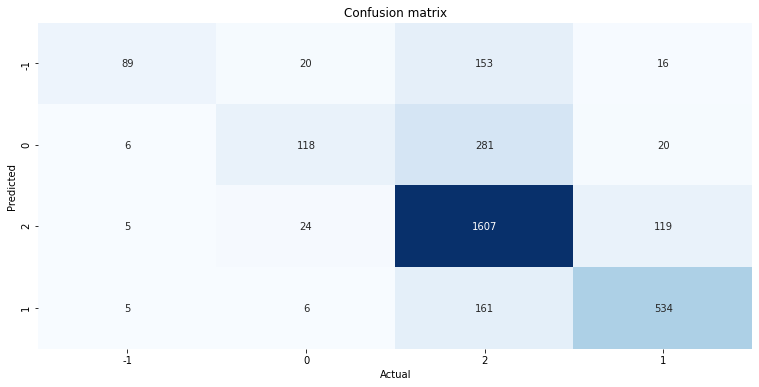

In [ ]:
aux_train = train[['sentiment', 'sentiment_code']].drop_duplicates().sort_values('sentiment_code')
conf_matrix = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            cbar=False,
            fmt='g',
            xticklabels=aux_train['sentiment'].values, 
            yticklabels=aux_train['sentiment'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

##Modelling with resampled data


Since there has already been an observation that the data is imbalanced, one must attempt improving the accuracy of the above modelling. 


This will be done by introducing resampling techniques, Downsampling and SMOTE.

###Downsampling

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/Stephane-Masamba/Team_4_CPT_ML-Classification/Mikael/train%20(1).csv')
print(train.head())

   sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954


In [ ]:
test = pd.read_csv('https://raw.githubusercontent.com/Stephane-Masamba/Team_4_CPT_ML-Classification/Mikael/test%20(1).csv')
print(test.head())

                                             message  tweetid
0  Europe will now be looking to China to make su...   169760
1  Combine this with the polling of staffers re c...    35326
2  The scary, unimpeachable evidence that climate...   224985
3  @Karoli @morgfair @OsborneInk @dailykos \nPuti...   476263
4  RT @FakeWillMoore: 'Female orgasms cause globa...   872928


Clean the data by calling the cleaning functions

In [ ]:
clean_text(train)
remove_stopwords(train)
entities(train)
lem_text(train)

,sentiment,message,tweetid
0,1,ORG chief donot think carbon dioxide main caus...,625221
1,1,It 's like lack evidence anthropogenic global ...,126103
2,2,RT @ RawStory : Researchers say three years ac...,698562
3,1,# TodayinMaker # WIRED : 2016 pivotal year war...,573736
4,1,"RT @ SoyNovioDeTodas : It 's 2016 , racist , s...",466954
...,...,...,...
15814,1,RT @ ezlusztig : They took material global war...,22001
15815,2,RT @ washingtonpost : How climate change could...,17856
15816,0,notiven : RT : nytimesworld : What Trump actua...,384248
15817,-1,RT @ sara8smiles : Hey liberals climate change...,819732


In [ ]:
train_majority = train[train.sentiment== 1]
train_0 = train[train.sentiment== 0]
train_2 = train[train.sentiment== 2]

train_minority = train[train.sentiment==-1]



In [ ]:
# Downsample majority classes
train_majority_downsampled = resample(train_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=1296,     # to match minority class
                                 random_state=123) # reproducible results


train_0_downsampled = resample(train_0, 
                                 replace=False,    
                                 n_samples=1296,     
                                 random_state=123) 

train_2_downsampled = resample(train_2, 
                                 replace=False,    
                                 n_samples=1296,     
                                 random_state=123) 

                      



# Combine minority class with downsampled majority class
train_downsampled1 = pd.concat([train_0_downsampled,train_2_downsampled])

train_downsampled2 = pd.concat([train_majority_downsampled, train_minority])

train_downsampled =  pd.concat([train_downsampled1, train_downsampled2])

In [ ]:
train_downsampled

,sentiment,message,tweetid
13470,0,RT @ Danky_Kong64 : Is really God ? Does globa...,574574
8148,0,Also storm global warming maybe probably,761606
11544,0,"RT @ AnnaKimbro : savor ur cold ones u , clima...",639609
7282,0,RT @ AceofSpadesHQ : 've begun miss days endle...,121132
12634,0,... .OMG 'celebrities ' 'moral actions climate...,744560
...,...,...,...
15704,-1,RT @ dbongino : We 're point w/the delusional ...,890582
15705,-1,RT @ joshdcaplan : Al Gore admits Paris Accord...,380307
15711,-1,RT @ JoshNoneYaBiz : Funny people believe clim...,390339
15806,-1,RT @ HerberMp : @ sness5561_ness Al Gore idiot...,213863


In [ ]:
train_downsampled['sentiment'].value_counts()

-1    1296
 2    1296
 1    1296
 0    1296
Name: sentiment, dtype: int64

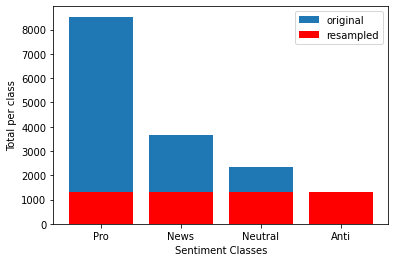

In [ ]:
counts = train["sentiment"].value_counts()
counti = train_downsampled['sentiment'].value_counts()

plt.bar(range(len(counts)), counts)
plt.bar(range(len(counts)),counti,color='red')
plt.xticks([0, 1, 2, 3], ['Pro', 'News', 'Neutral', 'Anti'])

plt.ylabel("Total per class")
plt.xlabel("Sentiment Classes")
plt.legend(['original','resampled'])
plt.show()

Now that the data is balanced, we go ahead and build a model. This time we check the performance with onlyy the two best performing models as per the above graph.

In [ ]:
X_down = train['message']
X_down

0        ORG chief donot think carbon dioxide main caus...
1        It 's like lack evidence anthropogenic global ...
2        RT @ RawStory : Researchers say three years ac...
3        # TodayinMaker # WIRED : 2016 pivotal year war...
4        RT @ SoyNovioDeTodas : It 's 2016 , racist , s...
                               ...                        
15814    RT @ ezlusztig : They took material global war...
15815    RT @ washingtonpost : How climate change could...
15816    notiven : RT : nytimesworld : What Trump actua...
15817    RT @ sara8smiles : Hey liberals climate change...
15818    RT @ Chet_Cannon : . @ kurteichenwald 's 'clim...
Name: message, Length: 15819, dtype: object

In [ ]:
y_down = train['sentiment']
y_down

0        1
1        1
2        2
3        1
4        1
        ..
15814    1
15815    2
15816    0
15817   -1
15818    0
Name: sentiment, Length: 15819, dtype: int64

In [ ]:
X_down = tf_vecto.fit_transform(X_down)
X_down

<15819x128009 sparse matrix of type '<class 'numpy.float64'>'
	with 363629 stored elements in Compressed Sparse Row format>

In [ ]:
#train_test_split
X_train1,X_test1,y_train1,y_test1 = train_test_split(X_down,y_down,test_size=0.2,random_state=0)

In [ ]:

lsvm = LinearSVC()
lsvm.fit(X_train1, y_train1)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
#confusion matrix and classification_report
y_pred1 = lsvm.predict(X_test1)

print(confusion_matrix(y_test1,y_pred1))

print('\n\nAccuracy score: ' + str(accuracy_score(y_test1, y_pred1)))
print("\n\nClassification Report:\n\n",classification_report(y_test1,y_pred1,target_names=['Anti', 'Neutral','Pro','News']))

[[  78   25  130   16]
 [   3  153  288   29]
 [   7   41 1539  114]
 [   4    8  171  558]]


Accuracy score: 0.7357774968394437


Classification Report:

               precision    recall  f1-score   support

        Anti       0.85      0.31      0.46       249
     Neutral       0.67      0.32      0.44       473
         Pro       0.72      0.90      0.80      1701
        News       0.78      0.75      0.77       741

    accuracy                           0.74      3164
   macro avg       0.76      0.57      0.62      3164
weighted avg       0.74      0.74      0.71      3164



In [ ]:
sentiment_code = {1:'Pro', 2:'News', 0:'Neutral', -1:'Anti'}

In [ ]:
train['sentiment_code'] = train['sentiment'].map(sentiment_code)

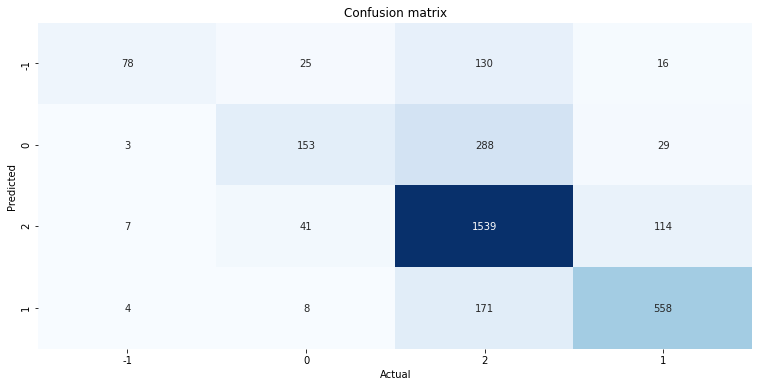

In [ ]:
aux_train = train[['sentiment', 'sentiment_code']].drop_duplicates().sort_values('sentiment_code')
conf_matrix = confusion_matrix(y_test1, y_pred1)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            cbar=False,
            fmt='g',
            xticklabels=aux_train['sentiment'].values, 
            yticklabels=aux_train['sentiment'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

###SMOTE 

Using data from the first data split

In [ ]:
print(X_train.shape,y_train.shape)

(12655, 128009) (12655,)


In [ ]:
smote = SMOTE("minority")
X_sm , y_sm = smote.fit_resample(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(X_sm.shape,y_sm.shape)

(18412, 128009) (18412,)


In [ ]:
ls= LinearSVC()
ls.fit(X_sm, y_sm)


#confusion matrix and classification_report
y_predsm = ls.predict(X_test)

print(confusion_matrix(y_test,y_predsm))

print('\n\nAccuracy score: ' + str(accuracy_score(y_test, y_predsm)))
print("\n\nClassification Report:\n\n",classification_report(y_test,y_predsm,target_names=['Anti', 'Neutral','Pro','News']))

[[ 135   24  108   11]
 [  15  142  250   18]
 [  21   39 1582  113]
 [   8    6  147  545]]


Accuracy score: 0.7597977243994943


Classification Report:

               precision    recall  f1-score   support

        Anti       0.75      0.49      0.59       278
     Neutral       0.67      0.33      0.45       425
         Pro       0.76      0.90      0.82      1755
        News       0.79      0.77      0.78       706

    accuracy                           0.76      3164
   macro avg       0.74      0.62      0.66      3164
weighted avg       0.75      0.76      0.74      3164



In [ ]:
sentiment_code = {1:'Pro', 2:'News', 0:'Neutral', -1:'Anti'}

In [ ]:
train['sentiment_code'] = train['sentiment'].map(sentiment_code)

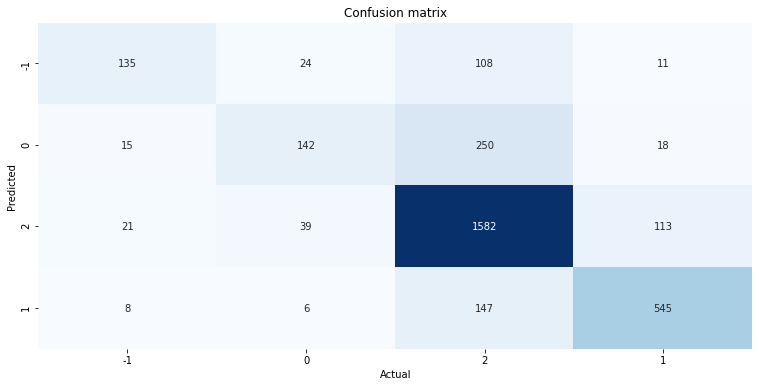

In [ ]:
aux_train = train[['sentiment', 'sentiment_code']].drop_duplicates().sort_values('sentiment_code')
conf_matrix = confusion_matrix(y_test, y_predsm)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            cbar=False,
            fmt='g',
            xticklabels=aux_train['sentiment'].values, 
            yticklabels=aux_train['sentiment'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

##Modelling with minimal data cleaning

To conclude the modelling section, we will explore what one could have done by intuition. This is just to check how accurate our model would be if we did not introduce the 'fancy' cleaning functions.

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/Stephane-Masamba/Team_4_CPT_ML-Classification/Mikael/train%20(1).csv')
print(train.head())

   sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954


In [ ]:
test = pd.read_csv('https://raw.githubusercontent.com/Stephane-Masamba/Team_4_CPT_ML-Classification/Mikael/test%20(1).csv')
print(test.head())


                                             message  tweetid
0  Europe will now be looking to China to make su...   169760
1  Combine this with the polling of staffers re c...    35326
2  The scary, unimpeachable evidence that climate...   224985
3  @Karoli @morgfair @OsborneInk @dailykos \nPuti...   476263
4  RT @FakeWillMoore: 'Female orgasms cause globa...   872928


In [ ]:
sample = pd.read_csv('https://raw.githubusercontent.com/Stephane-Masamba/Team_4_CPT_ML-Classification/Mikael/sample_submission.csv')
print(sample.head())


   tweetid  sentiment
0   169760          1
1    35326          1
2   224985          1
3   476263          1
4   872928          1


This time we only call one cleaning function which is the clean_text() function. This does not include tokenization as well as lemmatization

In [ ]:
clean_text(train)
remove_stopwords(train)

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,It 's like lack evidence anthropogenic global ...,126103
2,2,RT @ RawStory : Researchers say three years ac...,698562
3,1,# TodayinMaker # WIRED : 2016 pivotal year war...,573736
4,1,"RT @ SoyNovioDeTodas : It 's 2016 , racist , s...",466954
...,...,...,...
15814,1,RT @ ezlusztig : They took material global war...,22001
15815,2,RT @ washingtonpost : How climate change could...,17856
15816,0,notiven : RT : nytimesworld : What Trump actua...,384248
15817,-1,RT @ sara8smiles : Hey liberals climate change...,819732


In [ ]:
clean_text(test)
remove_stopwords(test)

,message,tweetid
0,europe looking china make sure alone fighting ...,169760
1,Combine polling staffers climate change womens...,35326
2,"The scary , unimpeachable evidence climate cha...",224985
3,@ Karoli @ morgfair @ OsborneInk @ dailykos Pu...,476263
4,RT @ FakeWillMoore : 'Female orgasms cause glo...,872928
...,...,...
10541,"RT @ BrittanyBohrer : Brb , writing poem clima...",895714
10542,2016 : year climate change came home : During ...,875167
10543,RT @ loop_vanuatu : Pacific countries positive...,78329
10544,"RT @ xanria_00018 : You ’ hot , must cause glo...",867455


###Features and Modelling

In [ ]:
X_min = train['message']
X_min


0        polyscimajor epa chief doesnt think carbon dio...
1        It 's like lack evidence anthropogenic global ...
2        RT @ RawStory : Researchers say three years ac...
3        # TodayinMaker # WIRED : 2016 pivotal year war...
4        RT @ SoyNovioDeTodas : It 's 2016 , racist , s...
                               ...                        
15814    RT @ ezlusztig : They took material global war...
15815    RT @ washingtonpost : How climate change could...
15816    notiven : RT : nytimesworld : What Trump actua...
15817    RT @ sara8smiles : Hey liberals climate change...
15818    RT @ Chet_Cannon : . @ kurteichenwald 's 'clim...
Name: message, Length: 15819, dtype: object

In [ ]:
y_min = train['sentiment']
y_min


0        1
1        1
2        2
3        1
4        1
        ..
15814    1
15815    2
15816    0
15817   -1
15818    0
Name: sentiment, Length: 15819, dtype: int64

###Convert to machine language

In [ ]:
X_min = tf_vecto.fit_transform(X_min)


In [ ]:
#train_test_split
X_train2,X_test2,y_train2,y_test2 = train_test_split(X_min,y_min,test_size=0.2,random_state=0)

###Stochastic Gradient Descent

In [ ]:
sgd = SGDClassifier()

sgd_accuracy = accuracy(sgd)
sgd_accuracy



[0.9718376617927584, 0.7389839975730764]

###Linear SVC

In [ ]:
linear_sv = LinearSVC()

linear_sv_accuracy = accuracy(linear_sv)
linear_sv_accuracy


[0.9995416918703649, 0.7466339226510063]

In [ ]:
linear_sv.fit(X_train2, y_train2)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
#confusion matrix and classification_report
y_pred2 = linear_sv.predict(X_test2)


print(confusion_matrix(y_test1,y_pred1))

print('\n\nAccuracy score: ' + str(accuracy_score(y_test2, y_pred1)))
print("\n\nClassification Report:\n\n",classification_report(y_test2,y_pred2,target_names=['Anti', 'Neutral','Pro','News']))

[[  78   25  130   16]
 [   3  153  288   29]
 [   7   41 1539  114]
 [   4    8  171  558]]


Accuracy score: 0.7357774968394437


Classification Report:

               precision    recall  f1-score   support

        Anti       0.85      0.31      0.46       249
     Neutral       0.67      0.32      0.44       473
         Pro       0.72      0.90      0.80      1701
        News       0.78      0.75      0.77       741

    accuracy                           0.74      3164
   macro avg       0.76      0.57      0.62      3164
weighted avg       0.74      0.74      0.71      3164



In [ ]:
sentiment_code = {1:'Pro', 2:'News', 0:'Neutral', -1:'Anti'}

In [ ]:
train['sentiment_code'] = train['sentiment'].map(sentiment_code)

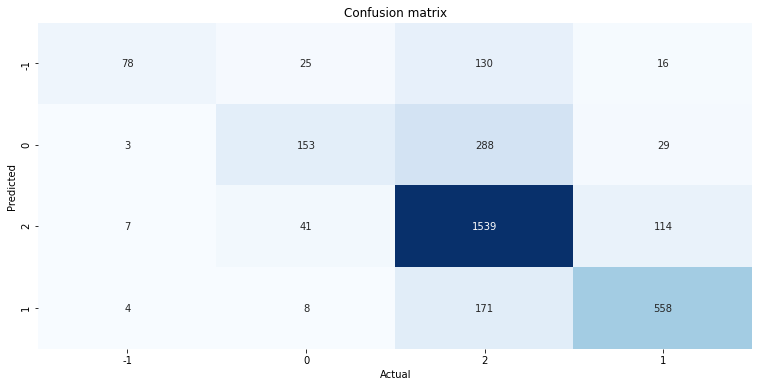

In [ ]:
aux_train = train[['sentiment', 'sentiment_code']].drop_duplicates().sort_values('sentiment_code')
conf_matrix = confusion_matrix(y_test1, y_pred1)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            cbar=False,
            fmt='g',
            xticklabels=aux_train['sentiment'].values, 
            yticklabels=aux_train['sentiment'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

#Results and ending comet experiment

In [ ]:
# import comet_ml in the top of your file
from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="kyaDe1YHDUV60KbpzF3dVpIuk",
                        project_name="general", workspace="rachel-ramonyai")

In [ ]:
f1 = f1_score(y_test, y_predsm,average='macro')
precision = precision_score(y_test, y_pred,average='macro')
recall = recall_score(y_test, y_pred,average='macro')

In [ ]:
params = {"kernel": 'linear',
          "model_type": "SVC",
          "stratify": True
          }

In [ ]:
params = {
          "model_type": "Best LinearSVC",
          "stratify": True
          }

metrics = {"f1": f1,
           "recall": recall,
           "precision": precision
           }

In [ ]:
# Log our parameters and results
experiment.log_parameters(params)
experiment.log_metrics(metrics)

In [ ]:
experiment.end()

#Submission

In [169]:
test

,message,tweetid
0,europe looking china make sure alone fighting ...,169760
1,Combine polling staffers climate change womens...,35326
2,"The scary , unimpeachable evidence climate cha...",224985
3,@ Karoli @ morgfair @ OsborneInk @ dailykos Pu...,476263
4,RT @ FakeWillMoore : 'Female orgasms cause glo...,872928
...,...,...
10541,"RT @ BrittanyBohrer : Brb , writing poem clima...",895714
10542,2016 : year climate change came home : During ...,875167
10543,RT @ loop_vanuatu : Pacific countries positive...,78329
10544,"RT @ xanria_00018 : You ’ hot , must cause glo...",867455


In [170]:
clean_text(test)
remove_stopwords(test)
entities(test)
lem_text(test)

,message,tweetid
0,LOC look GPE make sure alone fight climate change,169760
1,Combine polling staffers climate change womens...,35326
2,"The scary , unimpeachable evidence climate cha...",224985
3,@ Karoli @ morgfair @ OsborneInk @ dailykos Pu...,476263
4,RT @ FakeWillMoore : 'Female orgasms cause glo...,872928
...,...,...
10541,"RT @ BrittanyBohrer : Brb , writing poem clima...",895714
10542,2016 : year climate change came home : During ...,875167
10543,RT @ loop_vanuatu : Pacific countries positive...,78329
10544,"RT @ xanria_00018 : You ’ hot , must cause glo...",867455


In [171]:
X_tes = test['message']

In [172]:
X_tes = tf_vecto.transform(X_tes)

In [174]:
predictions = linear_sv.predict(X_tes)

In [175]:
test['sentiment'] = predictions
test

,message,tweetid,sentiment
0,LOC look GPE make sure alone fight climate change,169760,1
1,Combine polling staffers climate change womens...,35326,1
2,"The scary , unimpeachable evidence climate cha...",224985,1
3,@ Karoli @ morgfair @ OsborneInk @ dailykos Pu...,476263,1
4,RT @ FakeWillMoore : 'Female orgasms cause glo...,872928,0
...,...,...,...
10541,"RT @ BrittanyBohrer : Brb , writing poem clima...",895714,1
10542,2016 : year climate change came home : During ...,875167,1
10543,RT @ loop_vanuatu : Pacific countries positive...,78329,2
10544,"RT @ xanria_00018 : You ’ hot , must cause glo...",867455,0


In [176]:
submission = test[['tweetid', 'sentiment']]
submission

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0
...,...,...
10541,895714,1
10542,875167,1
10543,78329,2
10544,867455,0


#Model Analysis and Insights

accuracy on holdout data set is always lower and this shows that our model tends to be slightly overfitting the training data...best performing model is linear svc

#Conclusion

Through the classification techniques,companies will be able to  access a broad base of consumer sentiments, spanning multiple demographic and geographic categories and this will increasing their insights and inform  strategies.

This include adding to their market research efforts in gauging how their product or service may be received.
